# W266 Final Project

Authors: Satheesh Joseph, Catherine Mou, Yi Zhang

## Downloading and loading the data

We acquired the dataset from the researchers in the form of Sqlite `.db` files.

In [50]:
import os, sys, re, json, time, unittest
import itertools, collections
from importlib import reload
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import datetime

import numpy as np
from scipy import stats
import pandas as pd
import sqlite3
import unicodedata
import nltk

import tensorflow as tf
from sklearn import metrics
from sklearn import preprocessing
from sklearn.metrics import classification_report

In [51]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, Flatten, Lambda, LSTM, Conv1D, MaxPooling1D, Dropout, Activation, Embedding
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

import tensorflow.compat.v1 as tf1
from tensorflow.keras.models import Model
import tensorflow.compat.v1.keras.backend as K
import tensorflow_hub as hub

import tensorflow.keras as keras
from tensorflow.python.keras import utils


In [52]:
# Download the files if they're not here
if 'data' not in os.listdir('.') or not os.listdir('data'):
    os.system('wget https://storage.googleapis.com/mids-w266-final-project-data/yelpHotelData.db -P data/')
    os.system('wget https://storage.googleapis.com/mids-w266-final-project-data/yelpResData.db -P data/')
    print('Data downloaded successfully!')
else:
    print('Already downloaded data')

Already downloaded data


In [53]:
tf.__version__

'2.7.0'

In [54]:
con = sqlite3.connect('data/yelpResData.db')
cursor = con.cursor()
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
print(cursor.fetchall())

con = sqlite3.connect('data/yelpHotelData.db')
cursor = con.cursor()
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
print(cursor.fetchall())

[('review',), ('restaurant',), ('reviewer',)]
[('review',), ('sqlite_stat1',), ('sqlite_stat2',), ('reviewer',), ('hotel',)]


In [55]:
# Reading from the hotels database
hotels_db = sqlite3.connect("data/yelpHotelData.db")
hotels = pd.read_sql_query("SELECT * FROM hotel", hotels_db)
hotel_reviews = pd.read_sql_query("SELECT * FROM review WHERE flagged in ('Y', 'N')", hotels_db)
hotel_reviewers = pd.read_sql_query("SELECT * FROM reviewer", hotels_db)


print(f'The data set contains {len(hotels)} hotels, {len(hotel_reviews)} reviews, and {len(hotel_reviewers)} reviewers')

The data set contains 283086 hotels, 5858 reviews, and 5123 reviewers


In [56]:
# Reading from the restaurant database
restaurant_db = sqlite3.connect("data/yelpResData.db")
restaurant_db.text_factory = lambda x: x.decode("utf-8", errors='ignore')
restaurants = pd.read_sql_query("SELECT * FROM restaurant", restaurant_db)
restaurant_reviews = pd.read_sql_query("SELECT * FROM review WHERE flagged in ('Y', 'N')", restaurant_db)
restaurant_reviewers = pd.read_sql_query("SELECT * FROM reviewer", restaurant_db)


print(f'The data set contains {len(restaurants)} restaurants, {len(restaurant_reviews)} reviews, and {len(restaurant_reviewers)} reviewers')

The data set contains 242652 restaurants, 67019 reviews, and 16941 reviewers


In [57]:
# Data Cleaning
hotel_reviews['reviewContent'] = hotel_reviews['reviewContent'].apply(lambda x: unicodedata.normalize('NFKD', x))
hotel_reviews['date'] = hotel_reviews['date'].apply(lambda x: datetime.datetime.strptime(x.strip().split(' ')[-1], '%m/%d/%Y'))

restaurant_reviews['reviewContent'] = restaurant_reviews['reviewContent'].apply(lambda x: unicodedata.normalize('NFKD', x))
restaurant_reviews['date'] = restaurant_reviews['date'].apply(lambda x: datetime.datetime.strptime(x.strip().split(' ')[-1], '%m/%d/%Y'))


In [58]:
# Split data according to the research paper
hotel_X_test = hotel_reviews[hotel_reviews['date'] >= datetime.datetime(2012, 1, 1)]
hotel_y_test = hotel_X_test['flagged'] == 'Y'
hotel_X_tran_and_dev = hotel_reviews[hotel_reviews['date'] < datetime.datetime(2012, 1, 1)]
hotel_X_train, hotel_X_dev, hotel_y_train, hotel_y_dev = train_test_split(hotel_X_tran_and_dev, hotel_X_tran_and_dev['flagged']=='Y')

restaurant_X_test = restaurant_reviews[restaurant_reviews['date'] >= datetime.datetime(2012, 1, 1)]
restaurant_y_test = restaurant_X_test['flagged'] == 'Y'
restaurant_X_tran_and_dev = restaurant_reviews[restaurant_reviews['date'] < datetime.datetime(2012, 1, 1)]
restaurant_X_train, restaurant_X_dev, restaurant_y_train, restaurant_y_dev = train_test_split(restaurant_X_tran_and_dev, restaurant_X_tran_and_dev['flagged']=='Y')


# Exploratory Data Analysis

In [59]:
hotel_X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3402 entries, 2137 to 4381
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   date           3402 non-null   datetime64[ns]
 1   reviewID       3402 non-null   object        
 2   reviewerID     3402 non-null   object        
 3   reviewContent  3402 non-null   object        
 4   rating         3402 non-null   int64         
 5   usefulCount    3402 non-null   int64         
 6   coolCount      3402 non-null   int64         
 7   funnyCount     3402 non-null   int64         
 8   flagged        3402 non-null   object        
 9   hotelID        3402 non-null   object        
dtypes: datetime64[ns](1), int64(4), object(5)
memory usage: 292.4+ KB


In [60]:
restaurant_X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 42086 entries, 8721 to 57619
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   date           42086 non-null  datetime64[ns]
 1   reviewID       42086 non-null  object        
 2   reviewerID     42086 non-null  object        
 3   reviewContent  42086 non-null  object        
 4   rating         42086 non-null  int64         
 5   usefulCount    42086 non-null  int64         
 6   coolCount      42086 non-null  int64         
 7   funnyCount     42086 non-null  int64         
 8   flagged        42086 non-null  object        
 9   restaurantID   42086 non-null  object        
dtypes: datetime64[ns](1), int64(4), object(5)
memory usage: 3.5+ MB


In [61]:
reviews = pd.concat([restaurant_X_train, hotel_X_train.rename(columns={'hotelID':'restaurantID'})], ignore_index=True)
reviews.groupby('reviewerID').agg({"usefulCount": np.sum, 
                                   "coolCount": np.sum, 
                                   "funnyCount": np.sum}).sort_values(by=['usefulCount'], ascending=False)
reviews[reviews['reviewerID'] == 'w-w-k-QXosIKQ8HQVwU6IQ']['reviewContent']

12680    ***Graham Elliot serves up refined casual food...
28660    ***Alinea is truly a one-of-a-kind experience;...
45370    ***While the rooms are small, Hotel Felix is a...
Name: reviewContent, dtype: object

In [62]:
reviews.groupby('flagged').agg('sum')


,rating,usefulCount,coolCount,funnyCount
flagged,,,,
N,158117,44661,29491,25203
Y,21592,0,0,0


,date,reviewID,reviewerID,reviewContent,usefulCount,coolCount,funnyCount,flagged,restaurantID
rating,,,,,,,,,
1,1410,1410,1410,1410,1410,1410,1410,1410,1410
2,2870,2870,2870,2870,2870,2870,2870,2870,2870
3,5872,5872,5872,5872,5872,5872,5872,5872,5872
4,15319,15319,15319,15319,15319,15319,15319,15319,15319
5,14415,14415,14415,14415,14415,14415,14415,14415,14415


(array([ 1410.,     0.,  2870.,     0.,     0.,  5872.,     0., 15319.,
            0., 14415.]),
 array([1. , 1.4, 1.8, 2.2, 2.6, 3. , 3.4, 3.8, 4.2, 4.6, 5. ]),
 <BarContainer object of 10 artists>)

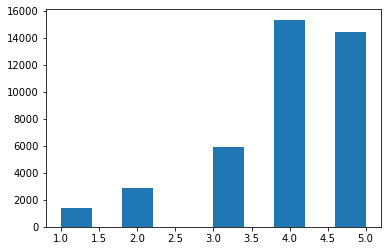

In [63]:
trueReviews = reviews[reviews['flagged'] == 'N']
fakeReviews = reviews[reviews['flagged'] == 'Y']
display(trueReviews.groupby('rating').agg('count'))
plt.hist(x=trueReviews.rating, bins=10)

,date,reviewID,reviewerID,reviewContent,usefulCount,coolCount,funnyCount,flagged,restaurantID
rating,,,,,,,,,
1,651,651,651,651,651,651,651,651,651
2,434,434,434,434,434,434,434,434,434
3,501,501,501,501,501,501,501,501,501
4,1510,1510,1510,1510,1510,1510,1510,1510,1510
5,2506,2506,2506,2506,2506,2506,2506,2506,2506


(array([ 651.,    0.,  434.,    0.,    0.,  501.,    0., 1510.,    0.,
        2506.]),
 array([1. , 1.4, 1.8, 2.2, 2.6, 3. , 3.4, 3.8, 4.2, 4.6, 5. ]),
 <BarContainer object of 10 artists>)

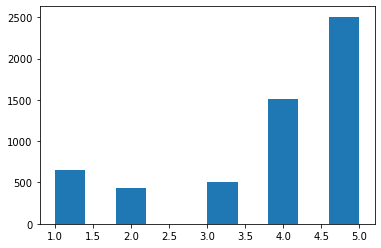

In [64]:
display(fakeReviews.groupby('rating').agg('count'))
plt.hist(x=fakeReviews.rating, bins=10)

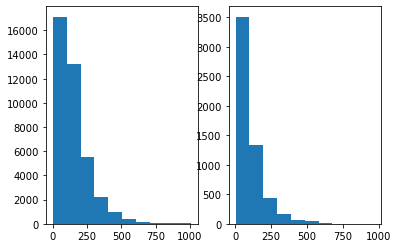

In [65]:
plt.subplot(1, 2, 1)
plt.hist(x = trueReviews['reviewContent'].str.count(' ') + 1)
plt.subplot(1, 2, 2)
plt.hist(x = fakeReviews['reviewContent'].str.count(' ') + 1)
plt.show()

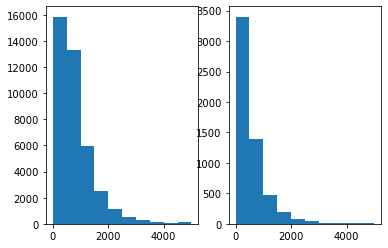

In [66]:
plt.subplot(1, 2, 1)
plt.hist(x = trueReviews['reviewContent'].str.count('.') + 1)
plt.subplot(1, 2, 2)
plt.hist(x = fakeReviews['reviewContent'].str.count('.') + 1)
plt.show()

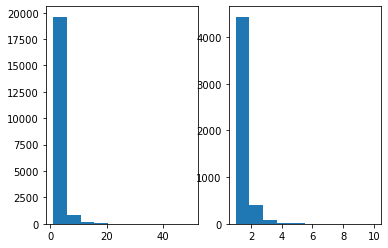

In [67]:
trueReviewerCounts = trueReviews.groupby(['reviewerID']).size().reset_index(name='counts')
fakeReviewerCounts = fakeReviews.groupby(['reviewerID']).size().reset_index(name='counts')


plt.subplot(1, 2, 1)
plt.hist(x = trueReviewerCounts['counts'], bins=10)
plt.subplot(1, 2, 2)
plt.hist(x = fakeReviewerCounts['counts'], bins=10)
plt.show()


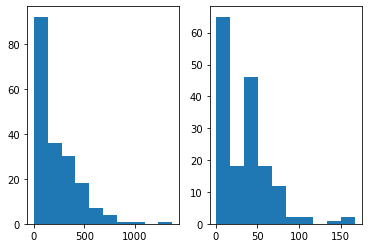

In [68]:
trueRestReviewCounts = trueReviews.groupby(['restaurantID']).size().reset_index(name='counts')
fakeRestReviewCounts = fakeReviews.groupby(['restaurantID']).size().reset_index(name='counts')


plt.subplot(1, 2, 1)
plt.hist(x = trueRestReviewCounts['counts'], bins=10)
plt.subplot(1, 2, 2)
plt.hist(x = fakeRestReviewCounts['counts'], bins=10)
plt.show()


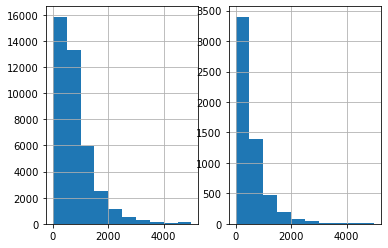

In [69]:
plt.subplot(1, 2, 1)
trueReviews['reviewContent'].str.len().hist()
plt.subplot(1, 2, 2)
fakeReviews['reviewContent'].str.len().hist()
plt.show()

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/anusatheesh/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


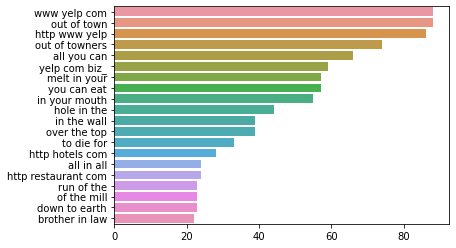

In [70]:
# Code Snippet for Top N-grams Barchart

import seaborn as sns
import numpy as np
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from collections import  Counter

nltk.download('stopwords')

def plot_top_ngrams_barchart(text, n=2):
    synthetic = {'gmail', 'they', 'http', 'www'}
    stop=set(stopwords.words('english')) | synthetic
    new= text.str.split()
    new= new.values.tolist()
    corpus=[word for i in new for word in i if word.lower() not in stop]

    def _get_top_ngram(corpus, n=None):
        vec = CountVectorizer(ngram_range=(n, n)).fit(corpus)
        bag_of_words = vec.transform(corpus)
        sum_words = bag_of_words.sum(axis=0) 
        words_freq = [(word, sum_words[0, idx]) 
                      for word, idx in vec.vocabulary_.items()]
        words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
        return words_freq[:20]

    top_n_bigrams=_get_top_ngram(corpus,n)[:20]
    x,y=map(list,zip(*top_n_bigrams))
    sns.barplot(x=y,y=x)
    

plot_top_ngrams_barchart(trueReviews['reviewContent'],3)

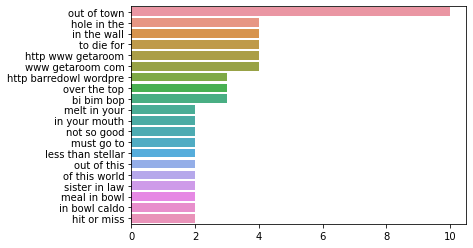

In [71]:
plot_top_ngrams_barchart(fakeReviews['reviewContent'],3)

In [72]:
fake_df = restaurant_reviews[restaurant_reviews['flagged'] == 'Y']["reviewerID"].to_frame()
true_df = restaurant_reviews[restaurant_reviews['flagged'] == 'N']["reviewerID"].to_frame()
print("Fake Reviewers " + str(len(fake_df["reviewerID"].unique())))
print("True Reviewers " + str(len(true_df["reviewerID"].unique())))
print("True and Fake Reviewers " + str(len(list(set(fake_df["reviewerID"].unique()) & set(true_df["reviewerID"].unique())))))

Fake Reviewers 7118
True Reviewers 28049
True and Fake Reviewers 138


In [73]:
full_rest_df = pd.merge(restaurant_reviews, restaurant_reviewers, on="reviewerID")
fake_df = full_rest_df[full_rest_df['flagged'] == 'Y']["firstCount"]
true_df = full_rest_df[full_rest_df['flagged'] == 'N']["firstCount"]
print("Fake stats Counts " + str(fake_df.count()) + str(" Sum ") + str(fake_df.sum()))
print("True stats Counts " + str(true_df.count()) + str(" Sum ") + str(true_df.sum()))

Fake stats Counts 6206 Sum 1549
True stats Counts 20752 Sum 225700


# Baseline Model

Try a Plain LSTM model on the Hotel data set with fixed length learned embedding

## Hotels Dataset

In [74]:
vocabulary_size = 20000
tokenizer = Tokenizer(num_words= vocabulary_size)
tokenizer.fit_on_texts(hotel_X_train['reviewContent'])
sequences = tokenizer.texts_to_sequences(hotel_X_train['reviewContent'])
hotel_train_data = pad_sequences(sequences, maxlen=100)

tokenizer = Tokenizer(num_words= vocabulary_size)
tokenizer.fit_on_texts(hotel_X_dev['reviewContent'])
sequences = tokenizer.texts_to_sequences(hotel_X_dev['reviewContent'])
hotel_dev_data = pad_sequences(sequences, maxlen=100)


In [75]:
model = Sequential()
model.add(Embedding(20000, 100, input_length=100))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


In [28]:
model.fit(hotel_train_data, hotel_y_train, epochs=2)

Epoch 1/2
107/107 [==============================] - 13s 102ms/step - loss: 0.4011 - accuracy: 0.8739
Epoch 2/2
107/107 [==============================] - 11s 103ms/step - loss: 0.3582 - accuracy: 0.8774


In [76]:
hotel_y_predicted = model.predict(hotel_dev_data)

/opt/anaconda3/lib/python3.8/site-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


RuntimeError: Attempted to use a closed Session.

In [30]:
print(classification_report(hotel_y_predicted > 0.5, hotel_y_dev))

              precision    recall  f1-score   support

       False       1.00      0.87      0.93      1134
        True       0.00      0.00      0.00         0

    accuracy                           0.87      1134
   macro avg       0.50      0.44      0.47      1134
weighted avg       1.00      0.87      0.93      1134



/Users/yizhang/Documents/MIDS/W266/w266-final-project/venv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/yizhang/Documents/MIDS/W266/w266-final-project/venv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/yizhang/Documents/MIDS/W266/w266-final-project/venv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  

# Model 2 - Data Resampling + GloVe embedding

In [31]:
# Download the GloVe embeddings
if 'embedding' not in os.listdir('.') or not os.listdir('embedding'):
    os.system('wget http://nlp.stanford.edu/data/glove.6B.zip -P embedding/')
    os.system('cd embedding && unzip glove.6B.zip')
    print('Data the GloVe embedding successfully!')
else:
    print('Already downloaded the embedding')

Already downloaded the embedding


In [32]:
# Use the 100 dimensional GloVe embedding
path_to_glove_file = "./embedding/glove.6B.100d.txt"

embeddings_index = {}
with open(path_to_glove_file) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

print("Found %s word vectors." % len(embeddings_index))

Found 400000 word vectors.


In [33]:
# Split the positive/negative samples for more balanced sampling
hotel_X_train_positive = hotel_X_train[hotel_X_train['flagged'] == 'Y']
hotel_X_train_negative = hotel_X_train[hotel_X_train['flagged'] == 'N']

print(f'There are {len(hotel_X_train_positive)} positive examples')
print(f'There are {len(hotel_X_train_negative)} negative examples')

num_samples = 2000
positive_ratio = 0.5
hotel_positives = hotel_X_train_positive.sample(int(num_samples * positive_ratio), replace=True).reset_index(drop=True)
hotel_negatives = hotel_X_train_negative.sample(num_samples, replace=True).reset_index(drop=True)

hotel_X_train_balanced = pd.concat([hotel_positives, hotel_negatives], ignore_index=True).sample(frac=1)
hotel_y_train_balanced = hotel_X_train_balanced['flagged'] == 'Y'


There are 417 positive examples
There are 2985 negative examples


In [34]:
# First layer, vectorizing the word input
vocabulary_size = 30000
max_tokens = 200

vectorizer = TextVectorization(max_tokens=vocabulary_size, output_sequence_length=max_tokens)
vectorizer.adapt(hotel_X_train_balanced['reviewContent'].to_numpy())

voc = vectorizer.get_vocabulary()
word_index = dict(zip(voc, range(len(voc))))

print(f"Vocabulary size is {len(voc)}")


Vocabulary size is 13740


In [35]:
# Ref: https://keras.io/examples/nlp/pretrained_word_embeddings/
# Build + Lock in the Embedding layer from GloVe
embedding_dim = 100
hits = 0
misses = 0
num_words = len(voc) + 2

# Prepare embedding matrix
# TODO: more pre-processing to avoid ~3000 words that don't have embeddings
embedding_matrix = np.zeros((num_words, embedding_dim))
for i, word in enumerate(voc):
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "padding" and "OOV"
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))


embedding_layer = Embedding(
    num_words,
    embedding_dim,
    embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
    trainable=False,
)


Converted 11145 words (2595 misses)


In [36]:
# Vectorize the input
hotel_X_train_ready = vectorizer(hotel_X_train_balanced['reviewContent']).numpy()
hotel_X_dev_ready = vectorizer(hotel_X_dev['reviewContent']).numpy()

hotel_X_train_ready.shape

(3000, 200)

In [37]:
# Build and train the model with 
model = Sequential()
model.add(embedding_layer)
model.add(LSTM(50, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model.fit(hotel_X_train_ready, hotel_y_train_balanced, epochs=8)

Epoch 1/8
94/94 [==============================] - 14s 128ms/step - loss: 0.6394 - accuracy: 0.6653
Epoch 2/8
94/94 [==============================] - 12s 130ms/step - loss: 0.6211 - accuracy: 0.6670
Epoch 3/8
94/94 [==============================] - 12s 129ms/step - loss: 0.6109 - accuracy: 0.6770
Epoch 4/8
94/94 [==============================] - 13s 140ms/step - loss: 0.5998 - accuracy: 0.6817
Epoch 5/8
94/94 [==============================] - 14s 145ms/step - loss: 0.5934 - accuracy: 0.6887
Epoch 6/8
94/94 [==============================] - 13s 134ms/step - loss: 0.5787 - accuracy: 0.6950
Epoch 7/8
94/94 [==============================] - 13s 133ms/step - loss: 0.5751 - accuracy: 0.6953
Epoch 8/8
94/94 [==============================] - 13s 134ms/step - loss: 0.5578 - accuracy: 0.7043


In [38]:
model.evaluate(hotel_X_dev_ready, hotel_y_dev)
hotel_y_predicted = model.predict(hotel_X_dev_ready)
print(classification_report(hotel_y_predicted > 0.5, hotel_y_dev))
hotel_X_dev['flagged'].value_counts() / len(hotel_X_dev)

36/36 [==============================] - 1s 18ms/step - loss: 0.4893 - accuracy: 0.8686
              precision    recall  f1-score   support

       False       0.99      0.87      0.93      1129
        True       0.00      0.00      0.00         5

    accuracy                           0.87      1134
   macro avg       0.50      0.44      0.46      1134
weighted avg       0.99      0.87      0.93      1134



N    0.873016
Y    0.126984
Name: flagged, dtype: float64

# Model 3: Train with generated fake reviews

In [ ]:
# Generating fake reviews from gpt-2 based on the training fake review set.
# Catherine ran it in an AWS instance and it takes a really long time.
# Commenting out the code to not run over and over again.
##########################
# !pip install transformers
# !pip install torch

# hotel_reviews_fake = hotel_X_train[hotel_X_train['flagged'] == 'Y']
# np.savetxt(r'data/hotel_fake.txt', hotel_reviews_fake['reviewContent'].values, fmt='%s')

# !python gpt2_fine_tuning.py \
#     --output_dir hotel \
#     --model_name_or_path=gpt2 \
#     --do_train \
#     --train_data_file='./data/hotel_fake.txt' \
#     --per_gpu_train_batch_size=1

# !python gpt2_generation.py \
#     --model_name_or_path hotel \
#     --length=10 \
#     --seed=3

In [41]:
# Load in previous generated fake reviews
with open('generated_hotel_fake.txt') as f:
    lines = f.read().splitlines()
    hotel_X_train_positive_generated = pd.DataFrame({'reviewContent':lines, 'flagged': 'Y'})


# Add generated fake reviews into the training set
hotel_X_train_positive = hotel_X_train[hotel_X_train['flagged'] == 'Y']
hotel_X_train_negative = hotel_X_train[hotel_X_train['flagged'] == 'N']

print(f'There are {len(hotel_X_train_positive)} positive examples')
print(f'There are {len(hotel_X_train_positive_generated)} generated positive examples')
print(f'There are {len(hotel_X_train_negative)} negative examples')

num_positive_needed = len(hotel_X_train_negative) - len(hotel_X_train_positive)
hotel_X_train_positive_generated_sampled = hotel_X_train_positive_generated.sample(n=num_positive_needed)
hotel_X_train_all_positive = pd.concat([hotel_X_train_positive, hotel_X_train_positive_generated_sampled], ignore_index=True)
hotel_X_train_balanced = pd.concat([hotel_X_train_all_positive, hotel_X_train_negative], ignore_index=True).sample(frac=1)
hotel_y_train_balanced = hotel_X_train_balanced['flagged'] == 'Y'

print(f"Training samples: {sum(hotel_X_train_balanced['flagged'] == 'Y')} positive, {sum(hotel_X_train_balanced['flagged'] == 'N')} negative")

# First layer, vectorizing the word input
vocabulary_size = 15000
max_sequence_length = 150

vectorizer = TextVectorization()#(max_tokens=vocabulary_size, output_sequence_length=max_sequence_length)
vectorizer.adapt(hotel_X_train_balanced['reviewContent'].to_numpy())

voc = vectorizer.get_vocabulary()
word_index = dict(zip(voc, range(len(voc))))

print(f"Vocabulary size is {len(voc)}")


# Building the embedding layer
# Ref: https://keras.io/examples/nlp/pretrained_word_embeddings/
# Build + Lock in the Embedding layer from GloVe
embedding_dim = 100
hits = 0
misses = 0
num_words = len(voc) + 2

# Prepare embedding matrix
# TODO: more pre-processing to avoid ~3000 words that don't have embeddings
embedding_matrix = np.zeros((num_words, embedding_dim))
for i, word in enumerate(voc):
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "padding" and "OOV"
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))


embedding_layer = Embedding(
    num_words,
    embedding_dim,
    embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
    trainable=False,
)


# Vectorize the input
hotel_X_train_ready = vectorizer(hotel_X_train_balanced['reviewContent']).numpy()
hotel_X_dev_ready = vectorizer(hotel_X_dev['reviewContent']).numpy()


# Build and train the model with 
model = Sequential()
model.add(embedding_layer)
model.add(LSTM(64, dropout=0.3, recurrent_dropout=0.3))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model.fit(hotel_X_train_ready, hotel_y_train_balanced, epochs=5)

model.evaluate(hotel_X_dev_ready, hotel_y_dev)
hotel_y_predicted = model.predict(hotel_X_dev_ready)
print(classification_report(hotel_y_predicted > 0.5, hotel_y_dev))
hotel_X_dev['flagged'].value_counts() / len(hotel_X_dev)


There are 417 positive examples
There are 3821 generated positive examples
There are 2985 negative examples
Training samples: 2985 positive, 2985 negative
Vocabulary size is 22616
Converted 16535 words (6081 misses)
Epoch 1/5
 41/187 [=====>........................] - ETA: 1:49 - loss: 0.6935 - accuracy: 0.5000

KeyboardInterrupt: 

In [32]:
# This is training BERT. BERT has its own preprocessing layer
import tensorflow_text as text  # Registers the ops.


# Load in previous generated fake reviews
with open('generated_hotel_fake.txt') as f:
    lines = f.read().splitlines()
    hotel_X_train_positive_generated = pd.DataFrame({'reviewContent':lines, 'flagged': 'Y'})


# Add generated fake reviews into the training set
hotel_X_train_positive = hotel_X_train[hotel_X_train['flagged'] == 'Y']
hotel_X_train_negative = hotel_X_train[hotel_X_train['flagged'] == 'N']

print(f'There are {len(hotel_X_train_positive)} positive examples')
print(f'There are {len(hotel_X_train_positive_generated)} generated positive examples')
print(f'There are {len(hotel_X_train_negative)} negative examples')

hotel_X_train_all_positive = pd.concat([hotel_X_train_positive, hotel_X_train_positive_generated], ignore_index=True)
hotel_X_train_more_positive = pd.concat([hotel_X_train_all_positive, hotel_X_train_negative], ignore_index=True).sample(frac=1)
hotel_y_train_more_positive = hotel_X_train_balanced['flagged'] == 'Y'

print(f"Training samples: {sum(hotel_X_train_more_positive['flagged'] == 'Y')} positive, {sum(hotel_X_train_more_positive['flagged'] == 'N')} negative")


def build_classifier_model():
    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string)
    preprocessor = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
    encoder_inputs = preprocessor(text_input)
    encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-256_A-4/2", trainable=True)
    outputs = encoder(encoder_inputs)

    net = outputs['pooled_output']
    net = tf.keras.layers.Dropout(0.2)(net)
    net = tf.keras.layers.Dense(1, activation='sigmoid', name='classifier')(net)
    return tf.keras.Model(text_input, net)

classifier_model = build_classifier_model()
classifier_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


classifier_model.summary()


There are 416 positive examples
There are 3821 generated positive examples
There are 2986 negative examples
Training samples: 4237 positive, 2986 negative
Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None,)]            0           []                               
                                                                                                  
 keras_layer_12 (KerasLayer)    {'input_mask': (Non  0           ['input_4[0][0]']                
                                e, 128),                                                          
                                 'input_word_ids':                                                
                                (None, 128),                                                      
                                 'in

In [35]:
# Seems to take ~1h per epoch :o
classifier_model.fit(hotel_X_train_balanced['reviewContent'], hotel_y_train_balanced, epochs=4)

classifier_model.evaluate(hotel_X_dev['reviewContent'], hotel_y_dev)

Epoch 1/4
187/187 [==============================] - 120s 641ms/step - loss: 0.3105 - accuracy: 0.8716
Epoch 2/4
187/187 [==============================] - 117s 624ms/step - loss: 0.2926 - accuracy: 0.8826
Epoch 3/4
187/187 [==============================] - 128s 684ms/step - loss: 0.2681 - accuracy: 0.8922
Epoch 4/4
36/36 [==============================] - 8s 209ms/step - loss: 0.5909 - accuracy: 0.7275


[0.5908752083778381, 0.7275132536888123]

In [36]:
hotel_y_predicted = classifier_model.predict(hotel_X_dev['reviewContent'])
print(classification_report(hotel_y_predicted > 0.5, hotel_y_dev))
hotel_X_dev['flagged'].value_counts() / len(hotel_X_dev)


              precision    recall  f1-score   support

       False       0.78      0.89      0.83       866
        True       0.36      0.19      0.25       268

    accuracy                           0.73      1134
   macro avg       0.57      0.54      0.54      1134
weighted avg       0.68      0.73      0.70      1134



N    0.872134
Y    0.127866
Name: flagged, dtype: float64

In [37]:
hotel_y_predicted = classifier_model.predict(hotel_X_test['reviewContent'])
print(classification_report(hotel_y_predicted > 0.5, hotel_y_test))
hotel_X_test['flagged'].value_counts() / len(hotel_X_test)


              precision    recall  f1-score   support

       False       0.78      0.87      0.82       988
        True       0.41      0.27      0.32       334

    accuracy                           0.72      1322
   macro avg       0.59      0.57      0.57      1322
weighted avg       0.68      0.72      0.69      1322



N    0.834342
Y    0.165658
Name: flagged, dtype: float64

# ELMo

In [124]:
tf1.disable_eager_execution()

def encode(le, labels):
    enc = le.transform(labels)
    return keras.utils.to_categorical(enc)

def decode(le, one_hot):
    dec = np.argmax(one_hot, axis=1)
    return le.inverse_transform(dec)

def ELMoEmbedding(x):
    return embed(tf.squeeze(tf.cast(x, tf.string)), signature="default", as_dict=True)["default"]

embed = hub.Module("https://tfhub.dev/google/elmo/3")

y = list(hotel_y_train)
x = list(hotel_X_train['reviewContent'])
le = preprocessing.LabelEncoder()
le.fit(y)
x_enc = x
y_enc = encode(le, y)

x_train = np.asarray(x_enc[:3402])
y_train = np.asarray(y_enc[:3402])

input_text = Input(shape=(1,), dtype=tf.string)
embedding = Lambda(ELMoEmbedding, output_shape=(1024, ))(input_text)
dense = Dense(256, activation='relu')(embedding)
pred = Dense(2, activation='softmax')(dense)
model = Model(inputs=[input_text], outputs=pred)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

with tf1.Session() as session:
    K.set_session(session)
    session.run(tf1.global_variables_initializer())
    #session.run(tf1.tables_initializer())
    history = model.fit(x_train, y_train, epochs=2, batch_size=32)
    model.save_weights('./elmo-hotel-model.h5')

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Train on 3402 samples
Epoch 1/3
3402/3402 [==============================] - 1819s 535ms/sample - loss: 0.3810 - accuracy: 0.8707
Epoch 2/3
3402/3402 [==============================] - 1664s 489ms/sample - loss: 0.3546 - accuracy: 0.8718
Epoch 3/3
3402/3402 [==============================] - 1698s 499ms/sample - loss: 0.3489 - accuracy: 0.8739


In [125]:
x_dev = np.asarray(list(hotel_X_dev['reviewContent'])[:1134])
y_dev_raw = np.asarray(encode(le, list(hotel_y_dev))[:1134]) 

with tf1.Session() as session:
    K.set_session(session)
    session.run(tf1.global_variables_initializer())
    #session.run(tf1.tables_initializer())
    model.load_weights('./elmo-hotel-model.h5')
    predicts = model.predict(x_dev, batch_size=32)

y_dev = decode(le, y_dev_raw)
y_preds = decode(le, predicts)

metrics.confusion_matrix(y_dev, y_preds)
print(metrics.classification_report(y_dev, y_preds))

/opt/anaconda3/lib/python3.8/site-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


              precision    recall  f1-score   support

       False       0.90      0.98      0.94      1010
        True       0.43      0.15      0.23       124

    accuracy                           0.89      1134
   macro avg       0.67      0.56      0.58      1134
weighted avg       0.85      0.89      0.86      1134



In [128]:
x_test = np.asarray(list(hotel_X_test['reviewContent'])[:1322])
y_test_raw = np.asarray(encode(le, list(hotel_y_test))[:1322]) 

with tf1.Session() as session:
    K.set_session(session)
    session.run(tf1.global_variables_initializer())
    #session.run(tf1.tables_initializer())
    model.load_weights('./elmo-hotel-model.h5')
    predicts = model.predict(x_test, batch_size=32)

y_test = decode(le, y_test_raw)
y_preds = decode(le, predicts)

metrics.confusion_matrix(y_test, y_preds)
print(metrics.classification_report(y_test, y_preds))

              precision    recall  f1-score   support

       False       0.85      0.96      0.90      1103
        True       0.43      0.14      0.21       219

    accuracy                           0.83      1322
   macro avg       0.64      0.55      0.56      1322
weighted avg       0.78      0.83      0.79      1322



In [ ]:
restaurant_y = list(restaurant_y_train)
restaurant_x = list(restaurant_X_train['reviewContent'])
restaurant_le = preprocessing.LabelEncoder()
restaurant_le.fit(restaurant_y)
restaurant_x_enc = restaurant_x
restaurant_y_enc = encode(restaurant_le, restaurant_y)

restaurant_x_train = np.asarray(restaurant_x_enc[:42086])
restaurant_y_train = np.asarray(restaurant_y_enc[:42086])

restaurant_embedding = Lambda(ELMoEmbedding, output_shape=(1024, ))(input_text)
restaurant_dense = Dense(256, activation='relu')(restaurant_embedding)
restaurant_pred = Dense(2, activation='softmax')(restaurant_dense)
restaurant_model = Model(inputs=[input_text], outputs=restaurant_pred)
restaurant_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

with tf1.Session() as session:
    K.set_session(session)
    session.run(tf1.global_variables_initializer())
    #session.run(tf1.tables_initializer())
    restaurant_history = restaurant_model.fit(restaurant_x_train, restaurant_y_train, epochs=2, batch_size=32)
    restaurant_model.save_weights('./elmo-restaurant-model.h5')

In [77]:
restaurant_x_dev = np.asarray(list(restaurant_X_dev['reviewContent'])[:14029])
restaurant_y_dev_raw = np.asarray(encode(restaurant_le, list(restaurant_y_dev))[:14029]) 

with tf1.Session() as session:
    K.set_session(session)
    session.run(tf1.global_variables_initializer())
    #session.run(tf1.tables_initializer())
    restaurant_model.load_weights('./elmo-restaurant-model.h5')
    restaurant_predicts = restaurant_model.predict(restaurant_x_dev, batch_size=32)

restaurant_y_dev = decode(restaurant_le, restaurant_y_dev_raw)
restaurant_y_preds = decode(restaurant_le, restaurant_predicts)

metrics.confusion_matrix(restaurant_y_dev, restaurant_y_preds)
print(metrics.classification_report(restaurant_y_dev, restaurant_y_preds))

              precision    recall  f1-score   support

       False       0.88      1.00      0.93     12292
        True       0.53      0.02      0.04      1737

    accuracy                           0.88     14029
   macro avg       0.70      0.51      0.49     14029
weighted avg       0.84      0.88      0.82     14029



In [78]:
restaurant_x_test = np.asarray(list(restaurant_X_test['reviewContent'])[:10904])
restaurant_y_test_raw = np.asarray(encode(le, list(restaurant_y_test))[:10904]) 

with tf1.Session() as session:
    K.set_session(session)
    session.run(tf1.global_variables_initializer())
    #session.run(tf1.tables_initializer())
    restaurant_model.load_weights('./elmo-restaurant-model.h5')
    restaurant_predicts = restaurant_model.predict(restaurant_x_test, batch_size=32)

restaurant_y_test = decode(restaurant_le, restaurant_y_test_raw)
restaurant_y_preds = decode(restaurant_le, restaurant_predicts)

metrics.confusion_matrix(restaurant_y_test, restaurant_y_preds)
print(metrics.classification_report(restaurant_y_test, restaurant_y_preds))

              precision    recall  f1-score   support

       False       0.87      1.00      0.93      9527
        True       0.30      0.01      0.03      1377

    accuracy                           0.87     10904
   macro avg       0.59      0.50      0.48     10904
weighted avg       0.80      0.87      0.82     10904



# 